In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math

import sys
sys.path.append('../scripts/code')

from pce import PCE
import distribution as distr
from test_functions_a import *

%matplotlib inline

In [46]:
seed = 0
np.random.seed(seed)

In [47]:
n_test = 10**7 #10**7 #!!!

In [4]:
sample_sizes = None

In [48]:
num_runs = 100 #30 #!!!

In [27]:
exp_name = 'experiments/test_risk_diff_basis_proj_13_'
save_all = True 

## Experiment: Sobol g-function

In [6]:
#  =======================================================================
# Define Sobol g-function



sobol_a =  [0, 0.5]# [0.0, 4.0] #[0.0, 1.0, 3.5]        #[1.7, 1.5, 0.5, 0.0, 1.0, 2.5, 0.0, 0.5, 0.7, 1] #  [0.0, 0.1]#  #[0.0, 0.5, 0.7, 1] #  # #  # [0, 0.5, 0.7, 1] #  
#a = [1.7, 1.5, 0.5, 0.0, 1.0, 2.5, 0.0, 0.5, 0.7, 1]

def function(X):
    return sobol_g_func(sobol_a, X)[:, np.newaxis]

dim = len(sobol_a)
lb = -1.0
ub = 1.0

true_Sobol_indices = get_indices_sobol_g_func(sobol_a, full=True)


#  ==================================================================
# Approximation setting

max_degrees = [4, 6, 9] #!!!



#  ==================================================================
# Experiment setting

start_power = 1.4 #!!!
end_power = 7 #!!!
num = 110 #5 #!!!


function_name = 'Sobol'
function_parameters = {'sobol_a':sobol_a}


In [28]:
exp_name += function_name

In [29]:
import os
import dill
print(dill.__version__)

db_name = exp_name+'.db'
if os.path.isfile(db_name):
    print('\n=============== Loading %s ======================\n'%db_name)
    dill.load_session(db_name) #!!!
    raise SystemExit("Workspace is loaded.")
else:
    print('Workspace %s not found'%db_name)

0.3.1.1
Workspace experiments/test_risk_diff_basis_proj_13_Sobol.db not found


### Code

In [49]:
ranges = lb * np.ones((dim, 2))
ranges[:, 0] = ub


test_X = np.random.rand(n_test, dim)
test_X = (ranges[:, 1] - ranges[:, 0]) * test_X + ranges[:, 0]


test_Y = function(test_X)

true_SI_full = true_Sobol_indices['main']
true_TI_full = true_Sobol_indices['total']

groups = tuple(true_SI_full.keys())

S_full = [true_SI_full[g] for g in groups]
T_full = [true_TI_full[g] for g in groups]


In [51]:
indices_full_number = len(groups)
indices_full_number

3

In [52]:
L = np.max(np.abs(test_Y))

var_f = np.var(test_Y)

var_f, L

(0.5307039287894791, 3.331021235661276)

In [11]:



def get_model_limit_mse(model, test_X, test_Y):
    
    test_size = int(len(test_X)*0.3)
    print('train size:', len(test_X)-test_size, ' + test size:', test_size)
    
    lambdas = np.array([0, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])
    
    err = []
    for ls_lambda in lambdas:
        model.fit(test_X[test_size:], test_Y[test_size:], method='ls', ls_lambda=ls_lambda)
        err += [ model.validate(test_X[:test_size], test_Y[:test_size])['mse'] ]
        
    err = np.array(err)
    print('Errors:', err)
    print('lambda opt:', lambdas[err == np.min(err)])
    
    return np.min(err)


In [12]:
%%time


#N = model._basis_functions_number

if sample_sizes is None:
    sample_sizes = np.logspace(start_power, end_power, num=num, endpoint=True, base=10.0, dtype=np.int)
print('sample_sizes', sample_sizes)
max_n = max(sample_sizes)


err_S_list_Legendre = []
err_S_list_Trigonometric = []
N_list = []

mse_list_Legendre = [] 
mse_list_Trigonometric = []



method = 'projection' #'ls' #'projection' # #!!!
print('\nMethod:', method, '\n')


for max_degree in max_degrees:
    
    print('\n======== max_degree:', max_degree, '============\n')
    
    appr_SI_Legendre =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
    appr_TI_Legendre =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))

    appr_SI_Trigonometric  =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
    appr_TI_Trigonometric  =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))
    
    for j in range(num_runs):

        print('\nRun', j, '\n')

        all_X = (ranges[:, 1] - ranges[:, 0]) * np.random.rand(max_n, dim) + ranges[:, 0]

        #sigma = 2*L 
        all_Y = function(all_X)#  + sigma * np.random.randn(max_n, 1)

        for i, n in enumerate(sample_sizes):

            print(i, n, 'training samples')

            X = all_X[:n].copy()
            Y = all_Y[:n].copy()
            
            marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Legendre')]*dim)
            model_Legendre = PCE(marginals, {'max_degree':max_degree})
            
            marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Trigonometric' )]*dim)
            model_Trigonometric = PCE(marginals, {'max_degree':max_degree})
        
            if method == 'projection' or model_Legendre._basis_functions_number <= n:
                
                model_Legendre.fit(X, Y, method=method)
                appr_SI_Legendre[j, i] = [model_Legendre.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
                appr_TI_Legendre[j, i] = [model_Legendre.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]
            
                model_Trigonometric.fit(X, Y, method=method)
                appr_SI_Trigonometric[j, i] = [model_Trigonometric.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
                appr_TI_Trigonometric[j, i] = [model_Trigonometric.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]
            
            else:
                appr_SI_Legendre[j, i] = np.nan
                appr_TI_Legendre[j, i] = np.nan
                appr_SI_Trigonometric[j, i]  = np.nan
                appr_TI_Trigonometric[j, i]  = np.nan
                
                
    indices_errors = np.dstack((np.abs(appr_SI_Legendre - S_full)**2, np.abs(appr_TI_Legendre- T_full)**2))
    mean_indices_errors = np.mean(indices_errors, axis=0)
    max_indices_errors = np.max(mean_indices_errors, axis=1)
    err_S_list_Legendre += [max_indices_errors]
    
    
    indices_errors = np.dstack((np.abs(appr_SI_Trigonometric - S_full)**2, np.abs(appr_TI_Trigonometric- T_full)**2))
    mean_indices_errors = np.mean(indices_errors, axis=0)
    max_indices_errors = np.max(mean_indices_errors, axis=1)
    err_S_list_Trigonometric += [max_indices_errors]
    
    N_list += [model_Legendre._basis_functions_number]
    
    mse_list_Legendre += [get_model_limit_mse(model_Legendre, test_X, test_Y)]
    mse_list_Trigonometric += [get_model_limit_mse(model_Trigonometric, test_X, test_Y)]   


    

sample_sizes [      25       28       31       35       40       45       51       57
       64       72       81       92      103      116      131      148
      166      187      211      237      267      301      339      381
      429      483      544      612      689      776      873      983
     1106     1245     1402     1578     1776     1999     2250     2533
     2851     3209     3612     4066     4576     5151     5798     6526
     7346     8268     9306    10475    11791    13271    14938    16814
    18926    21302    23978    26989    30378    34193    38487    43320
    48761    54884    61776    69534    78266    88095    99158   111610
   125626   141403   159160   179147   201644   226967   255469   287551
   323662   364307   410056   461551   519512   584753   658185   740840
   833874   938592  1056460  1189130  1338460  1506543  1695734  1908683
  2148375  2418166  2721838  3063645  3448376  3881421  4368848  4917485
  5535020  6230105  7012478  7893101  

/home/ivan/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Errors: [0.00353348 0.00353348 0.00353348 0.00353349 0.00353495 0.00368262
 0.01614147]
lambda opt: [1.e-05]
train size: 7000000  + test size: 3000000
Errors: [0.0013307  0.0013307  0.0013307  0.00133073 0.00133235 0.00148174
 0.01397069]
lambda opt: [0.]

======== max_degree: 9 ============


Run 0 

0 25 training samples
1 28 training samples
2 31 training samples
3 35 training samples
4 40 training samples
5 45 training samples
6 51 training samples
7 57 training samples
8 64 training samples
9 72 training samples
10 81 training samples
11 92 training samples
12 103 training samples
13 116 training samples
14 131 training samples
15 148 training samples
16 166 training samples
17 187 training samples
18 211 training samples
19 237 training samples
20 267 training samples
21 301 training samples
22 339 training samples
23 381 training samples
24 429 training samples
25 483 training samples
26 544 training samples
27 612 training samples
28 689 training samples
29 776 training samples

In [13]:
appr_TI_Trigonometric

array([[[0.90652135, 0.92342183, 1.        ],
        [0.85187113, 0.89165297, 1.        ],
        [0.83178395, 0.89169246, 1.        ],
        ...,
        [0.72097559, 0.37166649, 1.        ],
        [0.72104969, 0.37153385, 1.        ],
        [0.72095923, 0.37173267, 1.        ]],

       [[0.91235388, 0.88135954, 1.        ],
        [0.93402615, 0.91459848, 1.        ],
        [0.93670739, 0.92225474, 1.        ],
        ...,
        [0.72078603, 0.37221842, 1.        ],
        [0.72066415, 0.372464  , 1.        ],
        [0.72070311, 0.37232189, 1.        ]],

       [[0.84615133, 0.95272589, 1.        ],
        [0.8626462 , 0.94953249, 1.        ],
        [0.87051319, 0.92472555, 1.        ],
        ...,
        [0.72071239, 0.37176163, 1.        ],
        [0.72070588, 0.37191336, 1.        ],
        [0.7206133 , 0.37214471, 1.        ]],

       ...,

       [[0.92475225, 0.8941221 , 1.        ],
        [0.91795424, 0.90017756, 1.        ],
        [0.91666366, 0

In [14]:
err_S_list_Legendre

[array([2.94234926e-01, 2.86211824e-01, 2.85513094e-01, 2.73869475e-01,
        2.54994782e-01, 2.42494016e-01, 2.28889439e-01, 2.21643770e-01,
        2.09400667e-01, 1.91251112e-01, 1.77241431e-01, 1.59140660e-01,
        1.43628713e-01, 1.33522117e-01, 1.19952302e-01, 1.11838402e-01,
        9.75701911e-02, 8.71820490e-02, 7.61124294e-02, 6.69884255e-02,
        5.85624042e-02, 5.08573233e-02, 4.49660626e-02, 3.76805087e-02,
        3.20687971e-02, 2.74586500e-02, 2.27404966e-02, 1.92462618e-02,
        1.54737306e-02, 1.30113066e-02, 1.12262035e-02, 8.54124286e-03,
        7.08965584e-03, 5.46367890e-03, 4.59324950e-03, 3.68731589e-03,
        3.05517447e-03, 2.26850736e-03, 1.95579288e-03, 1.65552054e-03,
        1.49232647e-03, 1.24331037e-03, 1.01339431e-03, 8.20877855e-04,
        6.98625922e-04, 5.74798471e-04, 4.98096854e-04, 4.78281088e-04,
        3.99670060e-04, 3.59123776e-04, 2.95326789e-04, 2.18495796e-04,
        1.95803547e-04, 1.54224846e-04, 1.34347514e-04, 1.295051

In [15]:
str(model_Trigonometric)

"PCE(marginals=Marginals([Uniform(a=-1.0, b=1.0, Trigonometric), Uniform(a=-1.0, b=1.0, Trigonometric)]), basis_truncation={'max_degree': 9})"

In [61]:


file_save = 'risk_diff_basis_Sobol2_13' +'.npz' #!!!
np.savez(file_save, max_degrees, sample_sizes, 
         err_S_list_Legendre, mse_list_Legendre, 
         err_S_list_Trigonometric, mse_list_Trigonometric,
         L, N_list, var_f, num_runs,
         function_name, function_parameters) #!!!

In [17]:
# file_save = 'risk_diff_basis_Sobol2_5' +'.npz' #!!!

# loaded = np.load(file_save, allow_pickle=True)
# data = [loaded[key] for key in loaded]
# max_degrees, sample_sizes, err_S_list_Legendre, mse_list_Legendre, err_S_list_Trigonometric, mse_list_Trigonometric,L, N_list, var_f, num_runs, function_name, function_parameters = data

In [18]:
mse_list_Legendre 

[0.009037228032674049, 0.003533475489919383, 0.0017316040002917587]

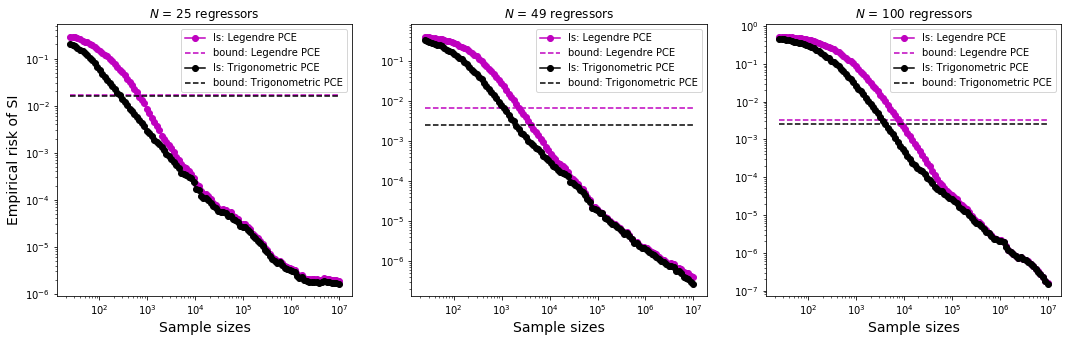

In [19]:
n_sig = len(err_S_list_Trigonometric) #len(sigma_list)

marker= 'o' # None #'o'
linestyle=None#'--'

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500


plt.figure(figsize=(18, 5))

for l in range(n_sig):
    

    plt.subplot(1, n_sig, l+1)
    #plt.title('$\sigma$ = {:.3f}'.format(sigma_list[l]))
    
    plt.title('$N$ = {} regressors'.format(N_list[l]))
    
    plt.loglog(sample_sizes[ind], err_S_list_Legendre[l][ind], label='ls: Legendre PCE',
               linestyle=linestyle, marker=marker, color='m')
    
    plt.loglog(sample_sizes[ind],  [mse_list_Legendre[l] / var_f]*sum(ind), label='bound: Legendre PCE',
               linestyle='--', marker=None, color='m')
        
        
    plt.loglog(sample_sizes[ind], err_S_list_Trigonometric[l][ind], label='ls: Trigonometric PCE',
               linestyle=linestyle, marker=marker, color='k')
    
    
    plt.loglog(sample_sizes[ind],  [mse_list_Trigonometric[l] / var_f]*sum(ind), label='bound: Trigonometric PCE',
               linestyle='--', marker=None, color='k')

    
    
# mse_list_Legendre / var_f
# mse_list_Trigonometric / var_f  


    #k = (L**2+sigma_list[l]**2) * N / var_f
    #plt.loglog(sample_sizes[ind], k/sample_sizes[ind], label='bound ($\sigma$)',linestyle='--', color='k')
    
    plt.xlabel('Sample sizes', fontsize=14)
    if l == 0:
        plt.ylabel('Empirical risk of SI', fontsize=14)
    plt.legend(loc='best')
    
# fname = 'risk_diff_basis_Sobol2_5' #!!!
# plt.savefig(fname, dpi=300) #!!!

In [92]:
from matplotlib.patches import Ellipse

def add_annotation(text,textcolor, xy, xytext):
    col = 'wheat'#,'papayawhip'#'blanchedalmond' #'oldlace'#'beige'#'ivory'#
    el = Ellipse((0, 0), 10, 20, facecolor=col, alpha=0.5)
    ann = ax.annotate(text,
                  xy=xy, xycoords='data',
                  xytext=xytext, textcoords='offset points',
                  size=fontsize,
                  color=textcolor,
                  bbox=dict(boxstyle="round",
                            color=col, #'w', # ,
                            ec=col), # 'wheat'
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  color=col, #'w', # 
                                  ec=col, # 'k',
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"),
                   clip_on=True)


===================== projection ===========================



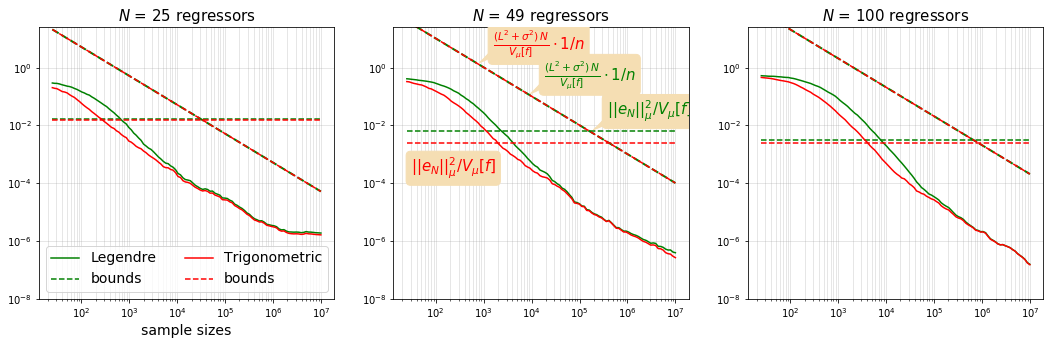

In [100]:
n_sig = len(err_S_list_Trigonometric) #len(sigma_list)

print('\n===================== %s ===========================\n'%method)

marker= "" # None #'o'
linestyle=None#'--'

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500

fontsize = 15




plt.figure(figsize=(18, 5))

for l in range(n_sig):

    ax = plt.subplot(1, n_sig, l+1)
    
    plt.title('$N$ = {} regressors'.format(N_list[l]), fontsize=fontsize)
    
    plt.loglog(sample_sizes[ind], err_S_list_Legendre[l][ind], label='Legendre',
               linestyle=linestyle, marker=marker, color='g')
    
    plt.loglog(sample_sizes[ind],  [mse_list_Legendre[l] / var_f]*sum(ind), label='bounds',
               linestyle='--', marker=None, color='g')
        
        
    plt.loglog(sample_sizes[ind], err_S_list_Trigonometric[l][ind], label='Trigonometric',
               linestyle=linestyle, marker=marker, color='r')
    
    k = L**2 * N_list[l] / var_f
    plt.loglog(sample_sizes[ind], k/sample_sizes[ind],linestyle='--', color='g', linewidth=2) # label='bound ($L, \sigma$)'
    plt.loglog(sample_sizes[ind], k/sample_sizes[ind],linestyle='--', color='r')
    
    
    
    plt.loglog(sample_sizes[ind],  [mse_list_Trigonometric[l] / var_f]*sum(ind), 
               label='bounds',
               linestyle='--', marker=None, color='r')
        
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
        
    plt.gca().set_ylim(bottom=10**-8)
    plt.gca().set_ylim(top=25)
    
    
    if l == 0:
        plt.xlabel('sample sizes', fontsize=14)
        plt.legend(loc='lower center', fontsize=fontsize-1, ncol=2) #  'best', 'upper right'

    if l == 2:
        pass
        
        
        
        
    if l == 1:
        add_annotation(text=r'$||e_N||^2_{\mu} / V_{\mu}[f]$', textcolor='g', 
                       xy=(1.8 * 10**5 , mse_list_Legendre[l] / var_f), xytext=(15, 15)) # r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$'
        #add_annotation(text=r'$||e_N||^2_{\mu} / V_{\mu}[f]}$', textcolor='r', 
        #                xy=(20 , mse_list_Trigonometric[l] / var_f), xytext=(25, 25)) # r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$'
        
        props = dict(boxstyle='round', facecolor='wheat', ec='wheat')
        ax.text(30, 0.9 * 10**-3, r'$||e_N||^2_{\mu} / V_{\mu}[f]}$',fontsize=fontsize,
                verticalalignment='top', bbox=props, color='r')



        add_annotation(text=r'$\frac{(L^2+\sigma^2) \, N }{V_{\mu}[f]} \cdot  1/n$', textcolor='r', 
                       xy=(750, k/750), xytext=(15, 15))
        add_annotation(text=r'$\frac{(L^2+\sigma^2) \, N }{V_{\mu}[f]} \cdot  1/n$', textcolor='g', 
                       xy=(8750, k/8750), xytext=(15, 15))
        
        

    
if save_all:
    fname = exp_name+'_6.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

In [21]:
# (L**2+sigma_list[l]**2) * N / var_f

In [22]:
# np.log10(N)

In [31]:
del model_Legendre, model_Trigonometric , marginals, test_X, test_Y, X, Y

In [32]:
import dill, os
print(dill.__version__)

if os.path.isfile(db_name):
    print('Not saved: file %s already exists'%db_name)
    
else:
    if save_all:
        dill.dump_session(db_name)
        print(db_name, 'is saved')

0.3.1.1
experiments/test_risk_diff_basis_proj_13_Sobol.db is saved
